In [1]:
import os
import random
import shutil
import pandas as pd
import pickle
import numpy as np
import seaborn as sns

from sklearn.datasets import load_files

# from keras.utils import to_categorical # Changed np_utils to to_categorical
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import warnings
warnings.filterwarnings('ignore')

2025-10-28 13:44:15.210002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761659055.378222      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761659055.429453      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os, random, shutil

def prepare_data(base_input_path, base_output_path, train_ratio=0.7, val_ratio=0.15):
    labels = [d for d in os.listdir(base_input_path) if os.path.isdir(os.path.join(base_input_path, d))]
    for label in labels:
        input_folder = os.path.join(base_input_path, label)
        images = os.listdir(input_folder)
        random.shuffle(images)
        
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        # Directories
        train_class_dir = os.path.join(base_output_path, 'training', label)
        val_class_dir = os.path.join(base_output_path, 'validation', label)
        test_class_dir = os.path.join(base_output_path, 'testing', label)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Copy images
        for i, img_name in enumerate(images):
            src_path = os.path.join(input_folder, img_name)
            if i < n_train:
                dest_path = os.path.join(train_class_dir, img_name)
            elif i < n_train + n_val:
                dest_path = os.path.join(val_class_dir, img_name)
            else:
                dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

# Example usage:
prepare_data(
    base_input_path="/kaggle/input/imagesoasis/Data",
    base_output_path="/kaggle/working/master_data",
    train_ratio=0.7,
    val_ratio=0.15
)

In [3]:
train_dir = "/kaggle/working/master_data/training"
validation_dir = "/kaggle/working/master_data/validation"
test_dir = "/kaggle/working/master_data/testing"
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 60504 images belonging to 4 classes.
Found 12964 images belonging to 4 classes.
Found 12969 images belonging to 4 classes.


In [4]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 4)


In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
# Input Layer
inputs = Input(shape=(224, 224, 3))

# ======================
# First Block
# ======================
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(inputs)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Second Block
# ======================
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Parallel Branches
# ======================

# Branch 1
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch1)

# Branch 2
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch2)

# Concatenate feature maps
concat = layers.Concatenate()([branch1, branch2])

# ======================
# Fully Connected Layers
# ======================
flatten = layers.Flatten()(concat)
dense1 = layers.Dense(64, activation='relu')(flatten)
outputs = layers.Dense(4, activation='softmax')(dense1)

I0000 00:00:1761659740.806534      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# Build Model
model = models.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │    147,584 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    590,080 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    147,520 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │    147,520 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 401408)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 25,690,176 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,095,748 (103.36 MB)

 Trainable params: 27,095,748 (103.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy', # Changed loss to categorical_crossentropy
             optimizer=optimizers.Adam(learning_rate=1e-4), # Corrected optimizer access and learning_rate
              metrics=['acc'])

In [8]:
train_samples=train_generator.samples
val_samples=val_generator.samples
test_samples=test_generator.samples
batch_size=16

In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [10]:
history=model.fit(train_generator,
                  epochs=4,
                  steps_per_epoch = train_samples // batch_size,
                  validation_data=val_generator,
                  validation_steps=val_samples // batch_size
                 ,class_weight=class_weights)

Epoch 1/4


I0000 00:00:1761659775.018412     122 service.cc:148] XLA service 0x7aea80003ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761659775.019096     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761659775.490102     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761659806.040578     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1891/3781 ━━━━━━━━━━━━━━━━━━━━ 8:41 276ms/step - acc: 0.5924 - loss: 0.9155

E0000 00:00:1761660376.324941     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761660376.558953     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761660377.420307     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761660377.676436     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3781/3781 ━━━━━━━━━━━━━━━━━━━━ 608s 152ms/step - acc: 0.6882 - loss: 0.6898 - val_acc: 0.9860 - val_loss: 0.0421
Epoch 2/4
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 534s 141ms/step - acc: 0.9839 - loss: 0.0279 - val_acc: 0.9985 - val_loss: 0.0059
Epoch 3/4
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 534s 141ms/step - acc: 0.9939 - loss: 0.0129 - val_acc: 0.9975 - val_loss: 0.0092
Epoch 4/4
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 534s 141ms/step - acc: 0.9960 - loss: 0.0092 - val_acc: 0.9834 - val_loss: 0.0590


In [11]:
# ======================
# 🔹 Save Weights
# ======================
model.save("/kaggle/working/driver_model.h5")

In [12]:
results = model.evaluate(test_generator,steps=len(test_generator), verbose=1)

print("Test Accuracy:", results[1])
print("Test Loss:", results[0])

405/406 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - acc: 0.9781 - loss: 0.0692

E0000 00:00:1761662051.660189     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761662051.895165     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761662053.124248     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761662053.382462     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


406/406 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - acc: 0.9782 - loss: 0.0692
Test Accuracy: 0.9807232618331909
Test Loss: 0.06198940798640251


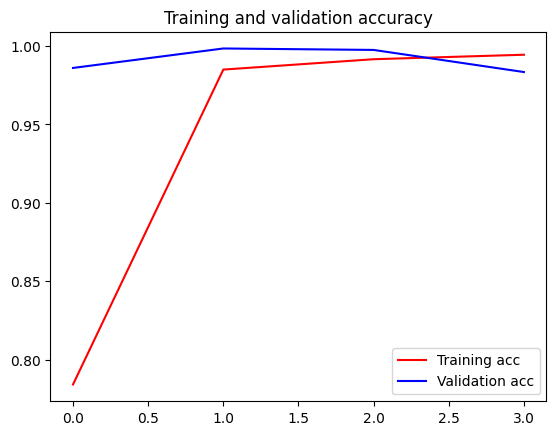

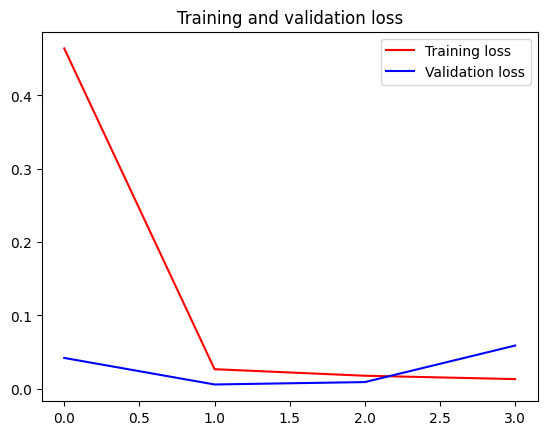

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# 1. Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

406/406 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - acc: 0.9782 - loss: 0.0692
Test Accuracy: 0.9807
 Test Loss: 0.0620


In [15]:
# 2. Predictions
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

406/406 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step


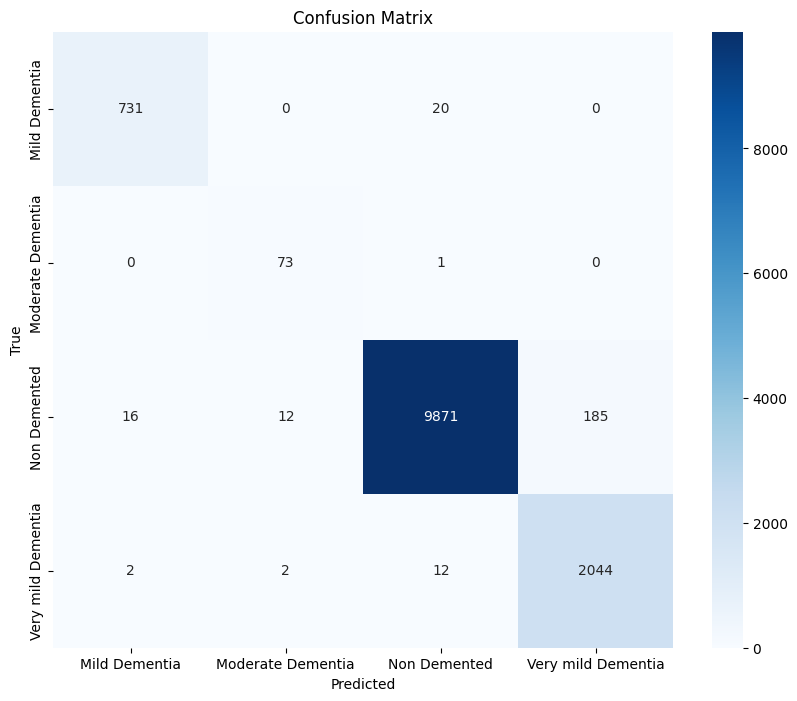

In [16]:
# 3. Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
from sklearn.metrics import classification_report
print("\n Classification Report:\n")
print(classification_report(test_generator.classes, y_pred,
                            target_names=list(test_generator.class_indices.keys())))


 Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       0.98      0.97      0.97       751
 Moderate Dementia       0.84      0.99      0.91        74
      Non Demented       1.00      0.98      0.99     10084
Very mild Dementia       0.92      0.99      0.95      2060

          accuracy                           0.98     12969
         macro avg       0.93      0.98      0.96     12969
      weighted avg       0.98      0.98      0.98     12969



In [18]:
# 5. Per-class accuracy
cm_diag = np.diag(cm) / np.sum(cm, axis=1)
for idx, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}: {cm_diag[idx]*100:.2f}% accuracy")

Class Mild Dementia: 97.34% accuracy
Class Moderate Dementia: 98.65% accuracy
Class Non Demented: 97.89% accuracy
Class Very mild Dementia: 99.22% accuracy


In [ ]:
import matplotlib.pyplot as plt

# Get the data from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# Plot Training and Validation Accuracy
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot Training and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()